## Import Libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats.mstats import winsorize
from numpy import array
pd.set_option('display.max_columns', None)

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## Download Files

In [2]:
# Load from a pickle file using pandas
train1 = pd.read_pickle('train1.pkl')# Load from a pickle file using pandas
test1 = pd.read_pickle('test1.pkl')# Load from a pickle file using pandas
score1 = pd.read_pickle('score1.pkl')# Load from a pickle file using pandas

In [3]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34888 entries, 0 to 34887
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   donorID                          34888 non-null  object 
 1   province                         34888 non-null  object 
 2   region                           34888 non-null  object 
 3   gender                           34888 non-null  object 
 4   language                         34888 non-null  object 
 5   age_group                        34888 non-null  object 
 6   total_donation_amount            34888 non-null  float64
 7   avg_donation_amount              34888 non-null  float64
 8   min_donation_amount              34888 non-null  float64
 9   max_donation_amount              34888 non-null  float64
 10  count_campaigns_participated     34888 non-null  float64
 11  count_donations                  34888 non-null  float64
 12  lor_years         

## Data preprocessing

###  Error correction

#### Outlier


In [4]:
# Create list of IVs excluding variables ending with '_na' (missing value indicators)
iv_list = train1.drop(['donorID', 'made_30_plus_gift'] + [col for col in train1.columns if col.endswith('_na')], axis=1)

dv_list = train1['made_30_plus_gift']

In [5]:
# Categorical variables
iv_cat_list = [v for v in iv_list if train1[v].dtypes == object]
print(len(iv_cat_list), iv_cat_list)

5 ['province', 'region', 'gender', 'language', 'age_group']


In [6]:
# Numerical variables
iv_num_list = [v for v in iv_list if v not in iv_cat_list]
print(len(iv_num_list), iv_num_list)

15 ['total_donation_amount', 'avg_donation_amount', 'min_donation_amount', 'max_donation_amount', 'count_campaigns_participated', 'count_donations', 'lor_years', 'recency_donation_days', 'amount_sum_last_6_months', 'amount_sum_last_12_months', 'amount_sum_last_18_months', 'amount_sum_last_24_months', 'province_avg', 'age_group_avg', 'avg_amount_30_plus']


## Winsorize

In [7]:
# List to store columns with outliers
columns_with_outliers = []

# print the outliers for numerical variables
tot_count = 0
tot_col = 0
for v in iv_num_list:
    
    # Calculate the lower and upper boundaries based on mean +/- 3*sd
    lower = train1[v].mean() - 3 * train1[v].std()
    upper = train1[v].mean() + 3 * train1[v].std()
    
    # Count the number of outliers
    cnt_outlier = sum((train1[v] < lower) | (train1[v] > upper))
    
    # Calculate the percentage of outliers values
    percentage_outliers = (cnt_outlier / len(train1)) * 100
    
    # Print out
    if cnt_outlier > 0:
        print(v, '[', train1[v].dtype, ']', cnt_outlier, 'outlier(s), % of outliers in column: {:.2f}'.format(percentage_outliers))
        tot_col += 1
        columns_with_outliers.append(v)  # Add column to the list
        
    tot_count += cnt_outlier

print("Train set has ", tot_count, " outliers, spread in ", tot_col, "columns")

total_donation_amount [ float64 ] 401 outlier(s), % of outliers in column: 1.15
avg_donation_amount [ float64 ] 297 outlier(s), % of outliers in column: 0.85
min_donation_amount [ float64 ] 275 outlier(s), % of outliers in column: 0.79
max_donation_amount [ float64 ] 338 outlier(s), % of outliers in column: 0.97
count_campaigns_participated [ float64 ] 341 outlier(s), % of outliers in column: 0.98
count_donations [ float64 ] 341 outlier(s), % of outliers in column: 0.98
amount_sum_last_6_months [ float64 ] 231 outlier(s), % of outliers in column: 0.66
amount_sum_last_12_months [ float64 ] 273 outlier(s), % of outliers in column: 0.78
amount_sum_last_18_months [ float64 ] 291 outlier(s), % of outliers in column: 0.83
amount_sum_last_24_months [ float64 ] 265 outlier(s), % of outliers in column: 0.76
avg_amount_30_plus [ float64 ] 306 outlier(s), % of outliers in column: 0.88
Train set has  3359  outliers, spread in  11 columns


In [8]:
# Winsorize columns with outliers

for column_name in columns_with_outliers:
    Q1 = train1[column_name].quantile(0.01)  # 1st percentile
    Q3 = train1[column_name].quantile(0.99)  # 99th percentile
    
    # Winsorize the values
    train1[column_name] = train1[column_name].clip(Q1, Q3)
    test1[column_name] = test1[column_name].clip(Q1, Q3)
    score1[column_name] = score1[column_name].clip(Q1, Q3)

In [9]:
test1.head()

,donorID,province,region,gender,language,age_group,total_donation_amount,avg_donation_amount,min_donation_amount,max_donation_amount,count_campaigns_participated,count_donations,lor_years,recency_donation_days,amount_sum_last_6_months,amount_sum_last_12_months,amount_sum_last_18_months,amount_sum_last_24_months,province_avg,age_group_avg,avg_amount_30_plus,total_donation_amount_na,avg_donation_amount_na,min_donation_amount_na,max_donation_amount_na,count_campaigns_participated_na,count_donations_na,lor_years_na,recency_donation_days_na,amount_sum_last_6_months_na,amount_sum_last_12_months_na,amount_sum_last_18_months_na,amount_sum_last_24_months_na,province_avg_na,age_group_avg_na,avg_amount_30_plus_na,made_30_plus_gift
0,D100001,Antwerp,Flanders,M,NL,41-50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
1,D100002,Antwerp,Flanders,M,NL,71-80,20.0,20.0,20.0,20.0,1.0,1.0,3.0,1342.0,0.0,0.0,0.0,0.0,31.172514,31.568304,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,D100008,Antwerp,Flanders,M,NL,41-50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
3,D100009,Antwerp,Flanders,M,NL,41-50,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0
4,D100010,Other,Brussels,M,FR,31-40,40.0,40.0,40.0,40.0,1.0,1.0,4.0,1603.0,0.0,0.0,0.0,0.0,25.043174,28.913073,40.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
'''
When running the models, we noticed overfitting (accuracy train_set >> accuracy test_set)
Thus, we decided not to scale the datasets
As a result, the models performances do not indicate overfitting anymore
'''

'\nWhen running the models, we noticed overfitting (accuracy train_set >> accuracy test_set)\nThus, we decided not to scale the datasets\nAs a result, the models performances do not indicate overfitting anymore\n'

In [11]:
# from sklearn.preprocessing import StandardScaler

# # Initialize the StandardScaler
# scaler = StandardScaler()

# # Scale the numeric columns
# train1[iv_num_list] = scaler.fit_transform(train1[iv_num_list])

In [12]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34888 entries, 0 to 34887
Data columns (total 37 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   donorID                          34888 non-null  object 
 1   province                         34888 non-null  object 
 2   region                           34888 non-null  object 
 3   gender                           34888 non-null  object 
 4   language                         34888 non-null  object 
 5   age_group                        34888 non-null  object 
 6   total_donation_amount            34888 non-null  float64
 7   avg_donation_amount              34888 non-null  float64
 8   min_donation_amount              34888 non-null  float64
 9   max_donation_amount              34888 non-null  float64
 10  count_campaigns_participated     34888 non-null  float64
 11  count_donations                  34888 non-null  float64
 12  lor_years         

In [13]:
# # Apply the train scaler to both test and score sets 
# test1[iv_num_list] = scaler.transform(test1[iv_num_list])
# test1[iv_num_list] = scaler.transform(test1[iv_num_list])

In [14]:
score1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26522 entries, 0 to 26521
Data columns (total 36 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   donorID                          26522 non-null  object 
 1   province                         26522 non-null  object 
 2   region                           26522 non-null  object 
 3   gender                           26522 non-null  object 
 4   language                         26522 non-null  object 
 5   age_group                        26522 non-null  object 
 6   total_donation_amount            26522 non-null  float64
 7   avg_donation_amount              26522 non-null  float64
 8   min_donation_amount              26522 non-null  float64
 9   max_donation_amount              26522 non-null  float64
 10  count_campaigns_participated     26522 non-null  float64
 11  count_donations                  26522 non-null  float64
 12  lor_years         

### Value transformation

- Categorical variables: encoding

## Categorical Encoding

In [15]:
# Encoding the categorical columns

# Iterate through categorical variables and apply one-hot encoding
for v in iv_cat_list:
    train1 = train1.join(pd.get_dummies(train1[v], prefix=v, drop_first=True))
# Drop the original categorical column
    train1.drop(v, axis=1, inplace=True)

# Now, do the same for the test set
for v in iv_cat_list:
    test1 = test1.join(pd.get_dummies(test1[v], prefix=v, drop_first=True))
# Drop the original categorical column for test
    test1.drop(v, axis=1, inplace=True)

    # Now, do the same for the score set
for v in iv_cat_list:
    score1 = score1.join(pd.get_dummies(score1[v], prefix=v, drop_first=True))
# Drop the original categorical column for test
    score1.drop(v, axis=1, inplace=True)



In [16]:
# Remove the 'D' character in front of donorID to make it suitable for algorithms

train1['donorID'] = train1['donorID'].str.lstrip('D').astype(int)
test1['donorID'] = test1['donorID'].str.lstrip('D').astype(int)
score1['donorID'] = score1['donorID'].str.lstrip('D').astype(int)


In [17]:
train1.head()

,donorID,total_donation_amount,avg_donation_amount,min_donation_amount,max_donation_amount,count_campaigns_participated,count_donations,lor_years,recency_donation_days,amount_sum_last_6_months,amount_sum_last_12_months,amount_sum_last_18_months,amount_sum_last_24_months,province_avg,age_group_avg,avg_amount_30_plus,total_donation_amount_na,avg_donation_amount_na,min_donation_amount_na,max_donation_amount_na,count_campaigns_participated_na,count_donations_na,lor_years_na,recency_donation_days_na,amount_sum_last_6_months_na,amount_sum_last_12_months_na,amount_sum_last_18_months_na,amount_sum_last_24_months_na,province_avg_na,age_group_avg_na,avg_amount_30_plus_na,made_30_plus_gift,province_East flanders,province_Flemish brabant,province_Limburg,province_Other,province_West flanders,region_Flanders,region_Wallonia,gender_M,language_NL,age_group_31-40,age_group_41-50,age_group_51-60,age_group_61-70,age_group_71-80,age_group_80+
0,100001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0
1,100002,20.0,20.0,20.0,20.0,1.0,1.0,2.0,1055.0,0.0,0.0,0.0,0.0,29.651334,28.57854,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0
2,100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0
3,100008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0
4,100009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0


In [18]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 34888 entries, 0 to 34887
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   donorID                          34888 non-null  int32  
 1   total_donation_amount            34888 non-null  float64
 2   avg_donation_amount              34888 non-null  float64
 3   min_donation_amount              34888 non-null  float64
 4   max_donation_amount              34888 non-null  float64
 5   count_campaigns_participated     34888 non-null  float64
 6   count_donations                  34888 non-null  float64
 7   lor_years                        34888 non-null  float64
 8   recency_donation_days            34888 non-null  float64
 9   amount_sum_last_6_months         34888 non-null  float64
 10  amount_sum_last_12_months        34888 non-null  float64
 11  amount_sum_last_18_months        34888 non-null  float64
 12  amount_sum_last_24

In [19]:
test1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25645 entries, 0 to 25644
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   donorID                          25645 non-null  int32  
 1   total_donation_amount            25645 non-null  float64
 2   avg_donation_amount              25645 non-null  float64
 3   min_donation_amount              25645 non-null  float64
 4   max_donation_amount              25645 non-null  float64
 5   count_campaigns_participated     25645 non-null  float64
 6   count_donations                  25645 non-null  float64
 7   lor_years                        25645 non-null  float64
 8   recency_donation_days            25645 non-null  float64
 9   amount_sum_last_6_months         25645 non-null  float64
 10  amount_sum_last_12_months        25645 non-null  float64
 11  amount_sum_last_18_months        25645 non-null  float64
 12  amount_sum_last_24

In [20]:
score1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26522 entries, 0 to 26521
Data columns (total 47 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   donorID                          26522 non-null  int32  
 1   total_donation_amount            26522 non-null  float64
 2   avg_donation_amount              26522 non-null  float64
 3   min_donation_amount              26522 non-null  float64
 4   max_donation_amount              26522 non-null  float64
 5   count_campaigns_participated     26522 non-null  float64
 6   count_donations                  26522 non-null  float64
 7   lor_years                        26522 non-null  float64
 8   recency_donation_days            26522 non-null  float64
 9   amount_sum_last_6_months         26522 non-null  float64
 10  amount_sum_last_12_months        26522 non-null  float64
 11  amount_sum_last_18_months        26522 non-null  float64
 12  amount_sum_last_24

## Model Building

In [22]:
import sys

from pandas                 import DataFrame
from numpy                  import array
from numpy                  import random
from sklearn.linear_model   import LogisticRegression
from sklearn.tree           import DecisionTreeClassifier
from sklearn.ensemble       import RandomForestClassifier
from sklearn.ensemble       import GradientBoostingClassifier
from sklearn.svm            import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors      import KNeighborsClassifier
from sklearn.metrics        import accuracy_score
from sklearn.metrics        import auc
from sklearn.metrics        import roc_auc_score
from matplotlib             import pyplot
from sklearn.metrics        import ConfusionMatrixDisplay
from sklearn.metrics        import confusion_matrix, accuracy_score
import kds
from scipy.stats          import pearsonr
from sklearn.preprocessing import StandardScaler
from ieseg import partition
from ieseg import roc
from ieseg import lift
from ieseg import cumulativeResponse
from ieseg import cumulativeGains
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold

## Training algorithms

 
We train the following algorithms on the training set :
* Decision tree
* Logistic regression
* Random forest
* Gradient boosting 
* Neural network
* Nearest neighbors


####  Set the features and target

In [23]:
selectedFeatures = []
target = "made_30_plus_gift"
exclude_variable = "donorID"
for col in train1.columns:
    if col not in exclude_variable:
        (pearson, pvalue) = pearsonr(train1[col], train1[target])
        print(f"{col} - p-value = {pvalue:.6f} - selected : {1 if pvalue < 0.001 else 0}")
        if pvalue < 0.001:
            selectedFeatures.append(col)


total_donation_amount - p-value = 0.000000 - selected : 1
avg_donation_amount - p-value = 0.000000 - selected : 1
min_donation_amount - p-value = 0.000000 - selected : 1
max_donation_amount - p-value = 0.000000 - selected : 1
count_campaigns_participated - p-value = 0.000000 - selected : 1
count_donations - p-value = 0.000000 - selected : 1
lor_years - p-value = 0.000000 - selected : 1
recency_donation_days - p-value = 0.058639 - selected : 0
amount_sum_last_6_months - p-value = 0.000000 - selected : 1
amount_sum_last_12_months - p-value = 0.000000 - selected : 1
amount_sum_last_18_months - p-value = 0.000000 - selected : 1
amount_sum_last_24_months - p-value = 0.000000 - selected : 1
province_avg - p-value = 0.000000 - selected : 1
age_group_avg - p-value = 0.000000 - selected : 1
avg_amount_30_plus - p-value = 0.000000 - selected : 1
total_donation_amount_na - p-value = 0.000000 - selected : 1
avg_donation_amount_na - p-value = 0.000000 - selected : 1
min_donation_amount_na - p-value

In [24]:
# Due to the large number of variables with pvalue=0, we run extra tests (Bonferroni)
# It adjusts the significance level by dividing it by the number of tests.
# This helps to control for the increased risk of false positives

In [25]:
# Number of variables being tested
num_variables = len(train1.columns) - 2  # Exclude 'donorID' and 'made_30_plus_gift'

# Bonferroni-corrected alpha
alpha_bonferroni = 0.05 / num_variables

# Loop through the variables and perform the test
selectedFeatures = []
target = "made_30_plus_gift"
exclude_variable = ["donorID", "made_30_plus_gift"]

for col in train1.columns:
    if col not in exclude_variable:
        (pearson, pvalue) = pearsonr(train1[col], train1[target])
        print(f"{col} - p-value = {pvalue:.6f} - selected : {1 if pvalue < alpha_bonferroni else 0}")
        if pvalue < alpha_bonferroni:
            selectedFeatures.append(col)


total_donation_amount - p-value = 0.000000 - selected : 1
avg_donation_amount - p-value = 0.000000 - selected : 1
min_donation_amount - p-value = 0.000000 - selected : 1
max_donation_amount - p-value = 0.000000 - selected : 1
count_campaigns_participated - p-value = 0.000000 - selected : 1
count_donations - p-value = 0.000000 - selected : 1
lor_years - p-value = 0.000000 - selected : 1
recency_donation_days - p-value = 0.058639 - selected : 0
amount_sum_last_6_months - p-value = 0.000000 - selected : 1
amount_sum_last_12_months - p-value = 0.000000 - selected : 1
amount_sum_last_18_months - p-value = 0.000000 - selected : 1
amount_sum_last_24_months - p-value = 0.000000 - selected : 1
province_avg - p-value = 0.000000 - selected : 1
age_group_avg - p-value = 0.000000 - selected : 1
avg_amount_30_plus - p-value = 0.000000 - selected : 1
total_donation_amount_na - p-value = 0.000000 - selected : 1
avg_donation_amount_na - p-value = 0.000000 - selected : 1
min_donation_amount_na - p-value

In [26]:
'''
Given the difficulty of analysis for these surprising results, we decide to run a last statistical test named Cohen.
Cohen's effect size measures the strength of the relationship.
We decide to only keep features with a medium to large effect size (practical significance), >=0.5

'''

"\nGiven the difficulty of analysis for these surprising results, we decide to run a last statistical test named Cohen.\nCohen's effect size measures the strength of the relationship.\nWe decide to only keep features with a medium to large effect size (practical significance), >=0.5\n\n"

In [27]:
# Threshold for significant Cohen's d
cohen_d_threshold = 0.5

# List to store selected features
selected_features = []

def cohen_d(x, y):
    """
    Calculate Cohen's d effect size.

    Parameters:
        x, y (pandas.Series): Two samples for which to calculate Cohen's d.

    Returns:
        float: Cohen's d effect size.
    """
    mean_diff = abs(x.mean() - y.mean())
    pooled_std_dev = ((x.std() ** 2 + y.std() ** 2) / 2) ** 0.5
    return mean_diff / pooled_std_dev

# Calculate Cohen's d for all variables
effect_sizes = {}
target = "made_30_plus_gift"

for col in train1.columns:
    if col not in ["donorID", "made_30_plus_gift"]:
        # Calculate Cohen's d for the current variable
        cohens_d = cohen_d(train1.loc[train1[target] == 1, col], train1.loc[train1[target] == 0, col])
        effect_sizes[col] = cohens_d

        # Check if Cohen's d is significant and greater than the threshold
        if abs(cohens_d) > cohen_d_threshold:
            selected_features.append(col)

# Display effect sizes
for variable, effect_size in effect_sizes.items():
    print(f"{variable}: Cohen's d = {effect_size:.6f}")

# Display selected features
print("\nSelected Features:")
print(selected_features)

total_donation_amount: Cohen's d = 0.515640
avg_donation_amount: Cohen's d = 0.567008
min_donation_amount: Cohen's d = 0.512251
max_donation_amount: Cohen's d = 0.584605
count_campaigns_participated: Cohen's d = 0.302488
count_donations: Cohen's d = 0.302488
lor_years: Cohen's d = 0.188177
recency_donation_days: Cohen's d = 0.061821
amount_sum_last_6_months: Cohen's d = 0.582514
amount_sum_last_12_months: Cohen's d = 0.582355
amount_sum_last_18_months: Cohen's d = 0.581200
amount_sum_last_24_months: Cohen's d = 0.572735
province_avg: Cohen's d = 0.382620
age_group_avg: Cohen's d = 0.370148
avg_amount_30_plus: Cohen's d = 0.547100
total_donation_amount_na: Cohen's d = 0.370515
avg_donation_amount_na: Cohen's d = 0.370515
min_donation_amount_na: Cohen's d = 0.370515
max_donation_amount_na: Cohen's d = 0.370515
count_campaigns_participated_na: Cohen's d = 0.370515
count_donations_na: Cohen's d = 0.370515
lor_years_na: Cohen's d = 0.370515
recency_donation_days_na: Cohen's d = 0.370515
amo

In [28]:
# pip install --upgrade scikit-learn


####  Instanciate the models

In [29]:
features = selectedFeatures
target = 'made_30_plus_gift'

In [30]:
tree         = DecisionTreeClassifier(class_weight='balanced')
logistic     = LogisticRegression(solver = "lbfgs", max_iter = 800,class_weight='balanced')
randomForest = RandomForestClassifier(n_estimators = 100,class_weight='balanced')
boostedTree  = GradientBoostingClassifier()
neuralNet    = MLPClassifier()
neighbors    = KNeighborsClassifier()

In [31]:
models = {"tree"         :tree,
          "logistic"     :logistic,
          "randomForest" :randomForest,
          "boostedTree"  :boostedTree,
          "neuralNet"    :neuralNet,
          "neighbors"    :neighbors
         }

#### Train the models on the training set

In [32]:
for model in models:
    models[model].fit(train1[features],train1[target])
    print(f"{model} has been trained successfully")

tree has been trained successfully
logistic has been trained successfully
randomForest has been trained successfully
boostedTree has been trained successfully
neuralNet has been trained successfully
neighbors has been trained successfully


####  Compute Accuracy and AUC for each model

In [33]:
performances = {}

for model in models:
    predictions   = models[model].predict(test1[features].to_numpy())
    probabilities = DataFrame(models[model].predict_proba(test1[features]))[1]
    accuracy      = accuracy_score(test1[target],predictions)
    auc           = roc_auc_score(array(test1[target]),array(probabilities))
    
    performances[model] = {"Accuracy":accuracy,"AUC":auc}

In [34]:
DataFrame(performances)

,tree,logistic,randomForest,boostedTree,neuralNet,neighbors
Accuracy,0.986274,0.814311,0.991733,0.992708,0.992279,0.991850
AUC,0.555135,0.729803,0.618153,0.681570,0.713812,0.651257


##  Evaluation

####  Neural Network

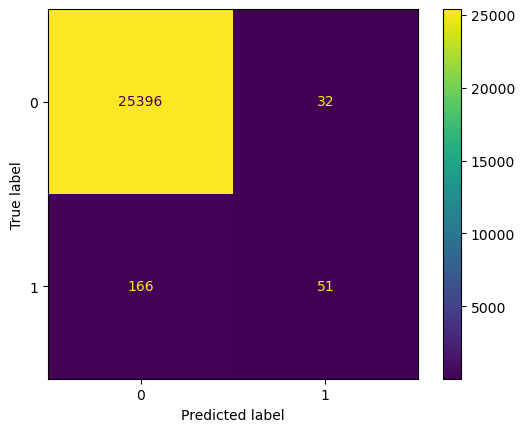

In [35]:
model = models['neuralNet']

# Predict probabilities for both training and test sets
train1['predicted_donator'] = model.predict_proba(train1[features])[:, 1]
test1['predicted_donator'] = model.predict_proba(test1[features])[:, 1]

# Convert probabilities to binary predictions using a threshold (e.g., 0.5)
threshold = 0.5
train1['predicted_donator_class'] = (train1['predicted_donator'] >= threshold).astype(int)
test1['predicted_donator_class'] = (test1['predicted_donator'] >= threshold).astype(int)

# Handle NaN values by dropping rows with NaN in the target variable
train1 = train1.dropna(subset=[target, 'predicted_donator'])
test1 = test1.dropna(subset=[target, 'predicted_donator'])

# Display confusion matrix for the test set
cm = confusion_matrix(test1[target], test1['predicted_donator_class'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
plt.show()


97.695482687457
99.24351725482549


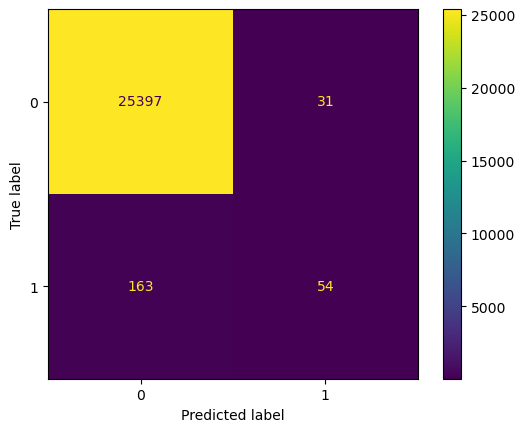

In [36]:
model = models["neuralNet"]
model.fit(train1[features],train1[target])

train1["predicted_donator"] = DataFrame(model.predict(train1[features]))
test1["predicted_donator"] = DataFrame(model.predict(test1[features]))
#calculate accuracy of trainingset
print(accuracy_score(train1[target],train1['predicted_donator'])*100)
#calculate accuracy of testset
print(accuracy_score(test1[target],test1['predicted_donator'])*100)
#plot a confusion matrix from the test set
cm = confusion_matrix(test1[target], test1['predicted_donator'], labels=model.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
pyplot.show()

In [37]:
train1['predicted_donator'].value_counts()

0    34699
1      189
Name: predicted_donator, dtype: int64

In [38]:
# Calculate probabilities
train1["predicted_donator"] = DataFrame(model.predict_proba(train1[features]))[1]
test1["predicted_donator"] = DataFrame(model.predict_proba(test1[features]))[1]  

# Handle NaN values 
train1 = train1.dropna(subset=[target, "predicted_donator"])
test1 = test1.dropna(subset=[target, "predicted_donator"])

# Calculate AUC scores
aucTraining = roc_auc_score(array(train1[target]), array(train1["predicted_donator"]))
aucTest = roc_auc_score(array(test1[target]), array(test1["predicted_donator"]))

print(f"auc training set: {aucTraining}")
print(f"auc test set: {aucTest}")

auc training set: 0.7468087473727723
auc test set: 0.6832451472269401


In [39]:
train1.head()

,donorID,total_donation_amount,avg_donation_amount,min_donation_amount,max_donation_amount,count_campaigns_participated,count_donations,lor_years,recency_donation_days,amount_sum_last_6_months,amount_sum_last_12_months,amount_sum_last_18_months,amount_sum_last_24_months,province_avg,age_group_avg,avg_amount_30_plus,total_donation_amount_na,avg_donation_amount_na,min_donation_amount_na,max_donation_amount_na,count_campaigns_participated_na,count_donations_na,lor_years_na,recency_donation_days_na,amount_sum_last_6_months_na,amount_sum_last_12_months_na,amount_sum_last_18_months_na,amount_sum_last_24_months_na,province_avg_na,age_group_avg_na,avg_amount_30_plus_na,made_30_plus_gift,province_East flanders,province_Flemish brabant,province_Limburg,province_Other,province_West flanders,region_Flanders,region_Wallonia,gender_M,language_NL,age_group_31-40,age_group_41-50,age_group_51-60,age_group_61-70,age_group_71-80,age_group_80+,predicted_donator,predicted_donator_class
0,100001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0.022484,0
1,100002,20.0,20.0,20.0,20.0,1.0,1.0,2.0,1055.0,0.0,0.0,0.0,0.0,29.651334,28.57854,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,1,0,0.012242,0
2,100004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0.022484,0
3,100008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0.022484,0
4,100009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0.022484,0


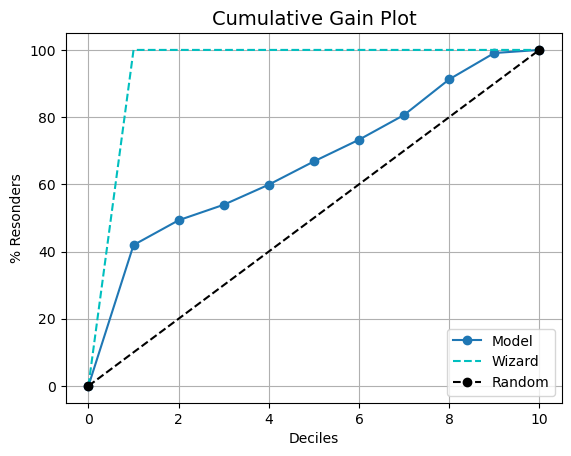

In [40]:
# CUMMULATIVE GAIN PLOT
kds.metrics.plot_cumulative_gain(test1[target],test1["predicted_donator"])

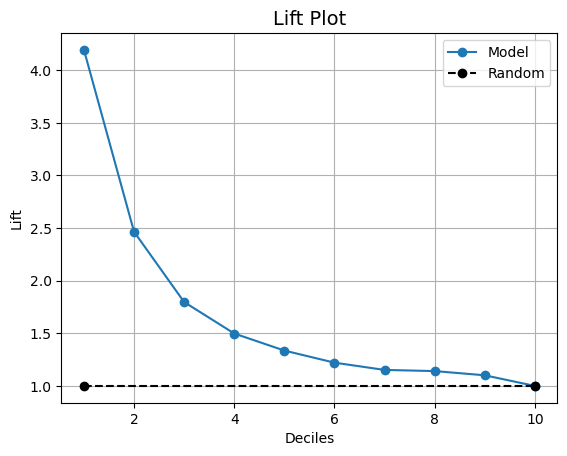

In [41]:
# LIFT PLOT
kds.metrics.plot_lift(test1[target],test1["predicted_donator"])

####  Logistic

87.69204310937859
81.43107818288165


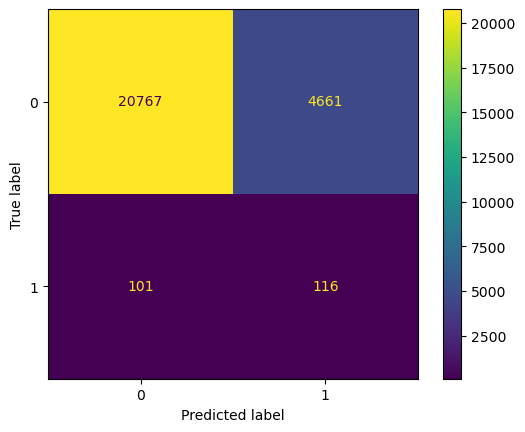

In [42]:
model = models["logistic"]
model.fit(train1[features],train1[target])

train1["predicted_donator"] = DataFrame(model.predict(train1[features]))
test1["predicted_donator"] = DataFrame(model.predict(test1[features])) 
#calculate accuracy of trainingset
print(accuracy_score(train1[target],train1['predicted_donator'])*100)
#calculate accuracy of testset
print(accuracy_score(test1[target],test1['predicted_donator'])*100)
#plot a confusion matrix from the test set
cm = confusion_matrix(test1[target], test1['predicted_donator'], labels=model.classes_)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
disp.plot()
pyplot.show()

In [43]:
train1["predicted_donator"] = DataFrame(model.predict(train1[features]))
test1["predicted_donator"] = DataFrame(model.predict(test1[features]))

aucTraining = roc_auc_score(array(train1[target]),array(train1["predicted_donator"]))
aucTest     = roc_auc_score(array(test1[target]),array(test1["predicted_donator"]))

print(f"auc training set : {aucTraining}")
print(f"auc test set     : {aucTest}")

auc training set : 0.6498569366001142
auc test set     : 0.6756301700146939


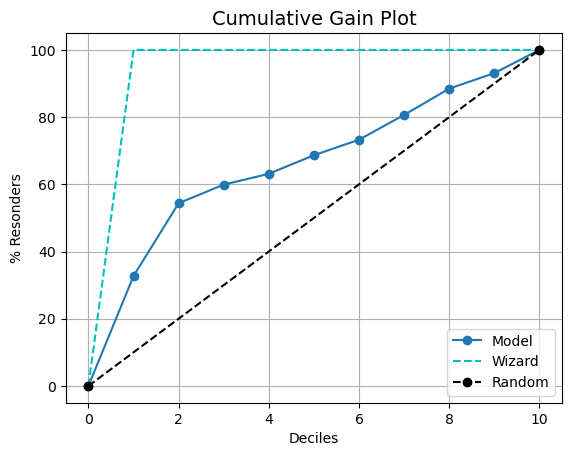

In [44]:
# CUMMULATIVE GAIN PLOT
kds.metrics.plot_cumulative_gain(test1[target],test1["predicted_donator"])

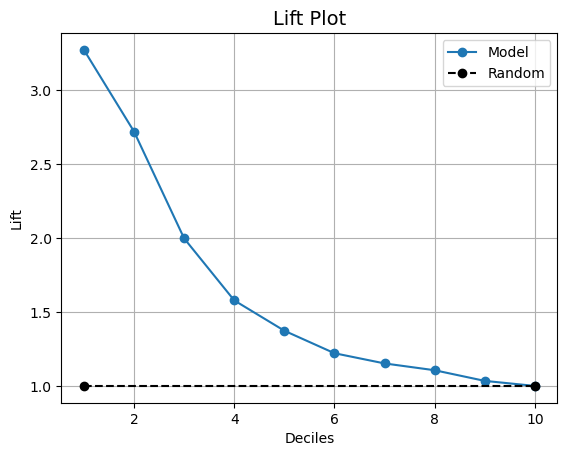

In [45]:
# LIFT PLOT
kds.metrics.plot_lift(test1[target],test1["predicted_donator"])

#### 3. What is the best model?

<b>The business has only the capacity to contact 20% of the customers</b>
* despite being lest robust overall, we can see that the neural network model performs better on the highest 20% percentile.
* on 20%, NN performs 2.5 times better than a random pick.
* on 20%, NN model succeeds in identifying -+50% of churners.

* Logistics does not seem reliable because of its large number of false positives.

## Applying the model to the score set

In [46]:
model = models["neuralNet"]
# Apply the model to the score set
score1['predicted_donator_prob'] = model.predict_proba(score1[features])[:, 1]

# Define a threshold to classify as donator or non-donator (adjust as needed)
threshold = 0.5
score1['predicted_donator_class'] = (score1['predicted_donator_prob'] > threshold).astype(int)

# Display the resulting DataFrame with predictions
print(score1[['donorID', 'predicted_donator_prob', 'predicted_donator_class']])


       donorID  predicted_donator_prob  predicted_donator_class
0       134242                0.022484                        0
1       126503                0.022484                        0
2       104392                0.022484                        0
3       105905                0.966812                        1
4       120506                0.022484                        0
...        ...                     ...                      ...
26517   114719                0.022484                        0
26518   134824                0.022484                        0
26519   143259                0.008335                        0
26520   123936                0.004741                        0
26521   128576                0.022484                        0

[26522 rows x 3 columns]


In [57]:
top20 = score1[score1['predicted_donator_class']==1].sort_values(by='predicted_donator_prob', ascending = False)
top20.head(20)

,donorID,total_donation_amount,avg_donation_amount,min_donation_amount,max_donation_amount,count_campaigns_participated,count_donations,lor_years,recency_donation_days,amount_sum_last_6_months,amount_sum_last_12_months,amount_sum_last_18_months,amount_sum_last_24_months,province_avg,age_group_avg,avg_amount_30_plus,total_donation_amount_na,avg_donation_amount_na,min_donation_amount_na,max_donation_amount_na,count_campaigns_participated_na,count_donations_na,lor_years_na,recency_donation_days_na,amount_sum_last_6_months_na,amount_sum_last_12_months_na,amount_sum_last_18_months_na,amount_sum_last_24_months_na,province_avg_na,age_group_avg_na,avg_amount_30_plus_na,province_East flanders,province_Flemish brabant,province_Limburg,province_Other,province_West flanders,region_Flanders,region_Missing,region_Wallonia,gender_M,language_NL,age_group_31-40,age_group_41-50,age_group_51-60,age_group_61-70,age_group_71-80,age_group_80+,predicted_donator_prob,predicted_donator_class
1115,107961,56.00,14.000000,6.50,30.0,4.0,4.0,1.0,45.0,7.565,15.00,22.10845,39.13,32.377433,30.577994,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,0,0.999946,1
18428,111483,175.00,70.000000,52.00,80.0,2.0,2.0,1.0,52.0,7.565,15.00,22.10845,39.13,31.973419,32.288260,75.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0.999852,1
12520,111778,180.00,66.000000,26.00,80.0,3.0,3.0,1.0,143.0,7.565,15.00,22.10845,39.13,31.973419,32.288260,75.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0.999814,1
20313,130052,175.00,70.000000,52.00,80.0,2.0,2.0,1.0,57.0,7.565,15.00,22.10845,39.13,28.139687,32.288260,75.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0.999798,1
23213,137368,180.00,70.000000,55.90,80.0,2.0,2.0,1.0,143.0,7.565,15.00,22.10845,39.13,32.377433,32.288260,75.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0.999796,1
20890,134501,175.00,70.000000,52.00,80.0,2.0,2.0,1.0,139.0,7.565,15.00,22.10845,39.13,30.867187,32.288260,75.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0.999769,1
1575,114402,180.00,70.000000,55.00,80.0,2.0,2.0,0.0,17.0,7.565,15.00,22.10845,39.13,28.139687,32.288260,75.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,1,0.999751,1
21032,108624,180.00,70.000000,55.90,80.0,3.0,3.0,1.0,120.0,7.565,15.00,22.10845,39.13,32.377433,32.288260,75.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0.999701,1
23472,126364,172.00,70.000000,52.00,80.0,2.0,2.0,1.0,44.0,7.565,15.00,22.10845,39.13,32.377433,32.312287,75.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0.999679,1
6797,129748,180.00,70.000000,50.70,80.0,3.0,3.0,4.0,127.0,7.565,15.00,22.10845,39.13,32.377433,32.288260,75.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0.999659,1


In [47]:
# Inspect the class frequency distribution of our predicted variable

In [48]:
score1['predicted_donator_class'].value_counts()

0    25682
1      840
Name: predicted_donator_class, dtype: int64

In [49]:
score1['predicted_donator_class'].value_counts(normalize=True)

0    0.968328
1    0.031672
Name: predicted_donator_class, dtype: float64

In [50]:
scored_set = score1[['donorID', 'predicted_donator_prob', 'predicted_donator_class']]

In [51]:
# Save the sorted dataframe to a CSV file
scored_set.to_csv('scored_set_proba.csv', index=False)